In [109]:
import os
import hashlib
import random
import matplotlib.pyplot as plt
import math
from PIL import Image
from PIL import ImageStat
import statistics
import numpy as np
import seaborn as sns

The dataset consists of over 7000 brain scan images. When working with image datasets, I find it essential to visually inspect the data.
I randomly sampled images from all classes to check for any elements that could introduce bias in the predictions.  

In medical imaging, especially when scans are taken during specific procedures, models may accidently learn features unrelated to the actual disease. For example, instead of recognizing a tumor or other condition, the model might pick up on artifacts such as annotations made by a doctor, differences in imaging devices used to take positive and negative samples, or the presence of medical equipment.

To ensure the model learns relevant patterns, it is crucial to verify that no external factors influence predictions.

At the beginning the dataset was deduplicated to prevent data leakage. About 300 duplicated samples were identified mainly in the negative class.

In [110]:
def find_duplicates(folder):
    hashes = set()
    duplicates = []

    for file in os.listdir(folder):
        if file.endswith(('png', 'jpg', 'jpeg')):
            
            hasher = hashlib.sha256()
            with open(os.path.join(folder, file), "rb") as f:
                while chunk := f.read(50):
                    hasher.update(chunk)
            img_hash = hasher.hexdigest()

            if img_hash in hashes:
                duplicates.append(os.path.join(folder, file))
            else:
                hashes.add(img_hash)

    return duplicates

In [111]:
duplicates0 = find_duplicates("archive/Data/0_notumor")
duplicates1 = find_duplicates("archive/Data/1_glioma")
duplicates2 = find_duplicates("archive/Data/2_meningioma")
duplicates3 = find_duplicates("archive/Data/3_pituitary")

In [112]:
duplicates = duplicates0+duplicates1+duplicates2+duplicates3

In [113]:
for img_path in duplicates:
    os.remove(img_path)

In [114]:
num_samples = 1000

In [115]:
glioma_images = []

images = random.sample(os.listdir(f"archive/Data/1_glioma"),num_samples)
for i in images:
    if i.endswith(('png', 'jpg', 'jpeg')):
        glioma_images.append(f"archive/Data/1_glioma/{i}")

In [116]:
meningioma_images = []

images = random.sample(os.listdir("archive/Data/2_meningioma"),num_samples)
for i in images:
    if i.endswith(('png', 'jpg', 'jpeg')):
        meningioma_images.append(f"archive/Data/2_meningioma/{i}")

In [117]:
pituitary_images = []

images = random.sample(os.listdir("archive/Data/3_pituitary"),num_samples)
for i in images:
    if i.endswith(('png', 'jpg', 'jpeg')):
        pituitary_images.append(f"archive/Data/3_pituitary/{i}")

In [118]:
negative_images = []

images = random.sample(os.listdir("archive/Data/0_notumor"),num_samples)
for i in images:
    if i.endswith(('png', 'jpg', 'jpeg')):
        negative_images.append(f"archive/Data/0_notumor/{i}")

In [119]:
def show_img(n_samples = 20, *args):

    image_list = []

    for arg in args:
        image_list += random.sample(arg, n_samples)

    size = len(image_list)
    fig, axes = plt.subplots(5, (math.ceil(size/5)), figsize=(15, 10)) 
    axes = axes.ravel()

    for i, im in enumerate(image_list):
        img = Image.open(im)
        axes[i].imshow(img)
        axes[i].set_title(im.split("_")[0][-1])
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

In [120]:
np.array(Image.open(negative_images[0])).shape

(225, 225, 3)

In [121]:
np.array(Image.open(meningioma_images[0])).shape

(512, 512)

In [122]:
print(np.array(Image.open(negative_images[0])).min(), np.array(Image.open(negative_images[0])).max())

print(np.array(Image.open(meningioma_images[0])).min(), np.array(Image.open(meningioma_images[0])).max())

0 255
0 254


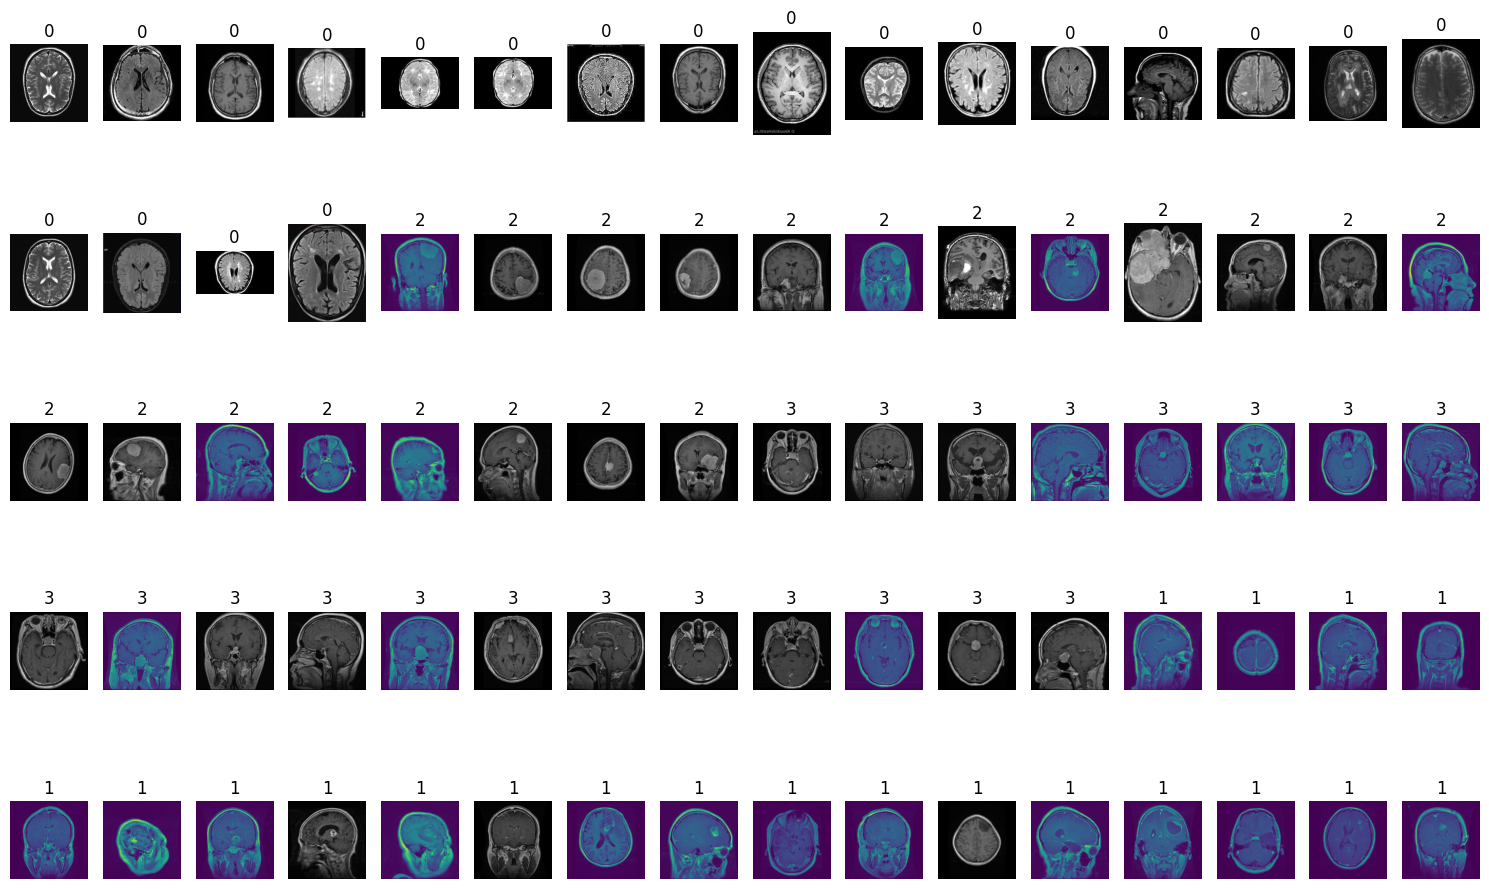

In [123]:
show_img(20, negative_images, meningioma_images, pituitary_images, glioma_images)

The images in the dataset are quite diverse—they vary in size, patient positioning, capture angles, colour profiles, and cropping.

In positive samples, there appear to be more true grayscale images (single-channel), whereas in the negative class, images are often in RGB format, even if they visually appear grayscale (with three identical channels). To ensure consistency, the dataset will likely require preprocessing steps such as uniform cropping, grayscale conversion, and resizing.

However the differences in the images can be already observed as different types of tumors give different MRI results:
- meningiomas (2) are typically located closer to the outer surface of the skull 
- pituitary tumors (3) develop within the pituitary gland, making them more likely to appear centrally on imaging
- gliomas (1) consist of glial cells and can develop in various parts of the brain and in the picture they appear in different parts of the skull. 

In [124]:
images = negative_images + meningioma_images + pituitary_images + glioma_images

In [125]:
def get_img_stats(images):
    brightness_list = []
    contrast_list = []
    size = []
    n_samples = 0
    for image in images:
        img = Image.open(image)
        im = img.convert("L")
        stat = ImageStat.Stat(im)
        brightness = stat.mean[0]
        contrast = stat.stddev[0]

        brightness_list.append(brightness)
        contrast_list.append(contrast)
        size.append(math.sqrt(im.size[0]*im.size[1]))
        n_samples += 1

    statis = {"mean_brightness": statistics.median(brightness_list), "mean_contrast": statistics.median(contrast_list), "size":statistics.median(size),"n_samples":n_samples}
    return statis

In [126]:
stats_0 = get_img_stats(negative_images)
stats_1 = get_img_stats(meningioma_images)
stats_2 = get_img_stats(pituitary_images)
stats_3 = get_img_stats(glioma_images)

In [127]:
print(f'''
class 0: {stats_0}
class 1: {stats_1}
class 2: {stats_2}
class 3: {stats_3}
''')


class 0: {'mean_brightness': 56.93674970329279, 'mean_contrast': 58.60139921267654, 'size': 225.0, 'n_samples': 1000}
class 1: {'mean_brightness': 41.51825523376465, 'mean_contrast': 46.20928289253676, 'size': 512.0, 'n_samples': 1000}
class 2: {'mean_brightness': 49.671409606933594, 'mean_contrast': 41.23486121384066, 'size': 512.0, 'n_samples': 999}
class 3: {'mean_brightness': 31.912418365478516, 'mean_contrast': 38.322538952526074, 'size': 512.0, 'n_samples': 999}



On average, samples from class 0 are lighter, have higher contrast, and smaller dimensions compared to other samples. This difference could be a result of the images being captured on different machines.

To prevent the model from making predictions based solely on differences in brightness, contrast, or size, it would be beneficial to normalize all images to a consistent brightness, contrast, and size. This standardization helps ensure that the model focuses on meaningful features rather than irrelevant image characteristics.

In [135]:
mean_bright = (stats_0["mean_brightness"] + stats_1["mean_brightness"]+ stats_2["mean_brightness"] + stats_3["mean_brightness"]) / 4 
mean_contrast = (stats_0["mean_contrast"] + stats_1["mean_contrast"]+ stats_2["mean_contrast"] + stats_3["mean_contrast"]) / 4 

In [136]:
mean_bright

45.00970822736738

In [137]:
mean_contrast

46.092020567895005

A universal PyTorch dataset was prepared to be used across different tests. The preprocessing steps include cropping, adjusting, resizing, and converting the images to grayscale. These transformations are applied using the ImageFolder class, and the processed images are saved to a file to enable using in different notebooks.

In [138]:
import torch 
import torchvision
from torchvision import datasets, transforms

In [139]:
def crop_img(img):
    w, h = img.size
    min_dim = min(img.size)
    left = (w - min_dim) // 2
    top = (h - min_dim) // 2
    right = left + min_dim
    bottom = top + min_dim
    return img.crop((left, top, right, bottom))


In [140]:
from PIL import ImageEnhance

def adjust_image(img):
        img = img.convert('L')
        stat = ImageStat.Stat(img)
        brightness = stat.mean[0]
        contrast = stat.stddev[0]

        img = ImageEnhance.Brightness(img).enhance(mean_bright / brightness)
        img = ImageEnhance.Contrast(img).enhance(mean_contrast / contrast)
        
        return img

In [141]:
transform = transforms.Compose([
    transforms.Lambda(crop_img),
    transforms.Lambda(adjust_image),
    transforms.Resize((128, 128)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

In [142]:
dataset = datasets.ImageFolder('archive/Data', transform=transform)

In [143]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))

classes = ("no_cancer", "G", "M", "P")

In [144]:
images, labels = next(iter(data_loader))

In [145]:
len(images)

6726

In [146]:
def show_image(tensor_img):
    plt.imshow(tensor_img.squeeze(), cmap='gray')
    plt.show()

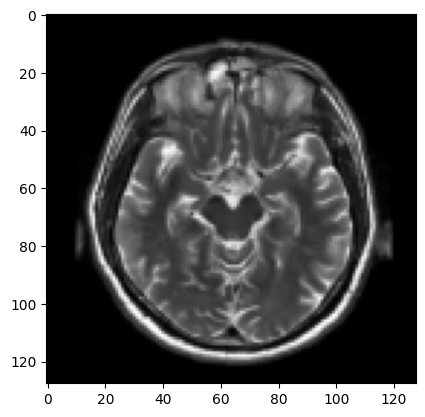

tensor(0)


In [147]:
sample_id = 5

show_image(images[sample_id])
print(labels[sample_id])

In [148]:
torch.save({'images': images, 'labels': labels}, 'dataset.pth')

In the end, the number of samples in each class was checked. Although the differences were not that big, the dataset was not perfectly balanced, to address this class weights were calculated.

<Axes: ylabel='Count'>

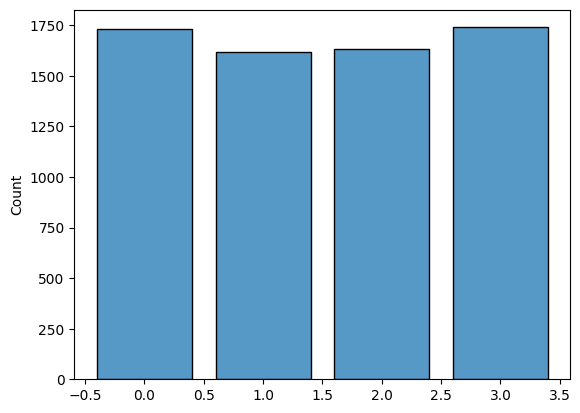

In [149]:
sns.histplot(data=labels, discrete=True, shrink=.8)

In [150]:
weights = torch.zeros((4))


for idx,label in enumerate(weights):
    weights[idx] = 1 - list(labels).count(idx) / len(labels)

weights

tensor([0.7426, 0.7591, 0.7569, 0.7413])

In [151]:
torch.save(weights, 'weights.pth')